***
# <center><font color=blue> **Data Camp - Starting Kit**</font></center>
***
#### <center> Mkrtich Vatinyan -- Danial Ghanbari -- Alexis Blanchet </center> 


## Introduction

we are here using a dataset from IBM to predict the probability customers will leave next month.

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 999

C:\Users\Alexis\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



### Loading all Datas

In [2]:
train_filename = 'data/train.csv'
test_filename = "data/test.csv"

In [3]:
train = pd.read_csv(train_filename)
test = pd.read_csv(test_filename)
y = train['Churn'].values
Y = [int(0) if i=='No' else int(1) for i in y]

# Data exploration

In [4]:
def save(y_pred):
    with open("submission_file.csv", 'w') as f:
        f.write("Id,Churn\n")
        for i in range(y_pred.shape[0]):
            f.write(str(i)+','+str(y_pred[i][1])+'\n')
        print('---File Saved---')

def fi(gb,name):
    trace = go.Scatter(
        y = gb.feature_importances_,
        x = features,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 13,
            #size= rf.feature_importances_,
            #color = np.random.randn(500), #set color equal to a variable
            color = gb.feature_importances_,
            colorscale='Portland',
            showscale=True
        ),
        text = features
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= name+' Feature Importance',
        hovermode= 'closest',
         xaxis= dict(
             ticklen= 5,
             showgrid=False,
            zeroline=False,
            showline=False
         ),
        yaxis=dict(
            title= 'Feature Importance',
            showgrid=False,
            zeroline=False,
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

def simple_test(X):
    if (type(X)==pd.core.frame.DataFrame):
        X = X.values
    Y = [int(0) if i=='No' else int(1) for i in y]
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.25, random_state=42)

    # Set our parameters for xgboost
    params = {}
    params['objective'] = 'binary:logistic'
    params['eval_metric'] = 'logloss'
    params['eta'] = 0.02
    params['max_depth'] = 4

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=100) 

In [5]:
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4433-JCGCG,Male,1,Yes,No,46,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.00,4680.05,Yes
1,1905-OEILC,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.50,19.5,No
2,8089-UZWLX,Female,1,No,No,71,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),104.05,7413.55,No
3,0575-CUQOV,Male,1,Yes,No,60,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Electronic check,97.95,5867,No
4,6827-IEAUQ,Female,0,Yes,Yes,27,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Mailed check,66.15,1874.45,No


In [6]:
train.values.shape

(5634, 21)

In [7]:
def func(r):
    if (r['TotalCharges']==' '):
         r['TotalCharges'] = 0
    r['TotalCharges'] = float(r['TotalCharges'])
    return r
train =train.apply(func,axis=1,raw=True)
test =test.apply(func,axis=1,raw=True)

In [8]:
train.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.165602,32.448172,64.676890,2278.239634
std,0.371756,24.532850,30.163528,2259.910271
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.400000,402.712500
50%,0.000000,29.000000,70.200000,1411.500000
75%,0.000000,55.000000,90.000000,3769.125000
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
train.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [10]:
train.count()

customerID          5634
gender              5634
SeniorCitizen       5634
Partner             5634
Dependents          5634
tenure              5634
PhoneService        5634
MultipleLines       5634
InternetService     5634
OnlineSecurity      5634
OnlineBackup        5634
DeviceProtection    5634
TechSupport         5634
StreamingTV         5634
StreamingMovies     5634
Contract            5634
PaperlessBilling    5634
PaymentMethod       5634
MonthlyCharges      5634
TotalCharges        5634
Churn               5634
dtype: int64

In [11]:
#%%file feature_extractor.py

from sklearn import preprocessing

class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, train,test):
        a = train.drop(['SeniorCitizen','tenure','MonthlyCharges','customerID','TotalCharges','Churn'],axis=1)
        b = test.drop(['SeniorCitizen','tenure','MonthlyCharges','customerID','TotalCharges'],axis=1)
        X_df = pd.concat([a,b])
        d = pd.get_dummies(X_df)
        n,_ = train.shape
        tr = d[:n]
        te = d[n+1:]
        tr['SeniorCitizen']= train['SeniorCitizen']
        tr['tenure']= train['tenure']
        tr['MonthlyCharges']= train['MonthlyCharges']
        tr['TotalCharges']= pd.to_numeric(train['TotalCharges'])
        te['SeniorCitizen']= test['SeniorCitizen']
        te['tenure']= test['tenure']
        te['MonthlyCharges']= test['MonthlyCharges']
        te['TotalCharges']= pd.to_numeric(test['TotalCharges'])
        return tr.values,te.values,tr
        
F = FeatureExtractor()
X_train,X_test,df = F.transform(train,test)

In [12]:
df.head(10)

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,46,101.00,4680.05
1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,19.50,19.50
2,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,71,104.05,7413.55
3,0,1,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1,60,97.95,5867.00
4,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,27,66.15,1874.45
5,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,30,110.45,3327.05
6,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,8,94.00,773.65
7,1,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,30.55,30.55
8,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,37,95.25,3314.15
9,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,31,73.90,2217.15


In [13]:
data = [go.Bar(
            x = train["Churn"].value_counts().index.values,
            y = train["Churn"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

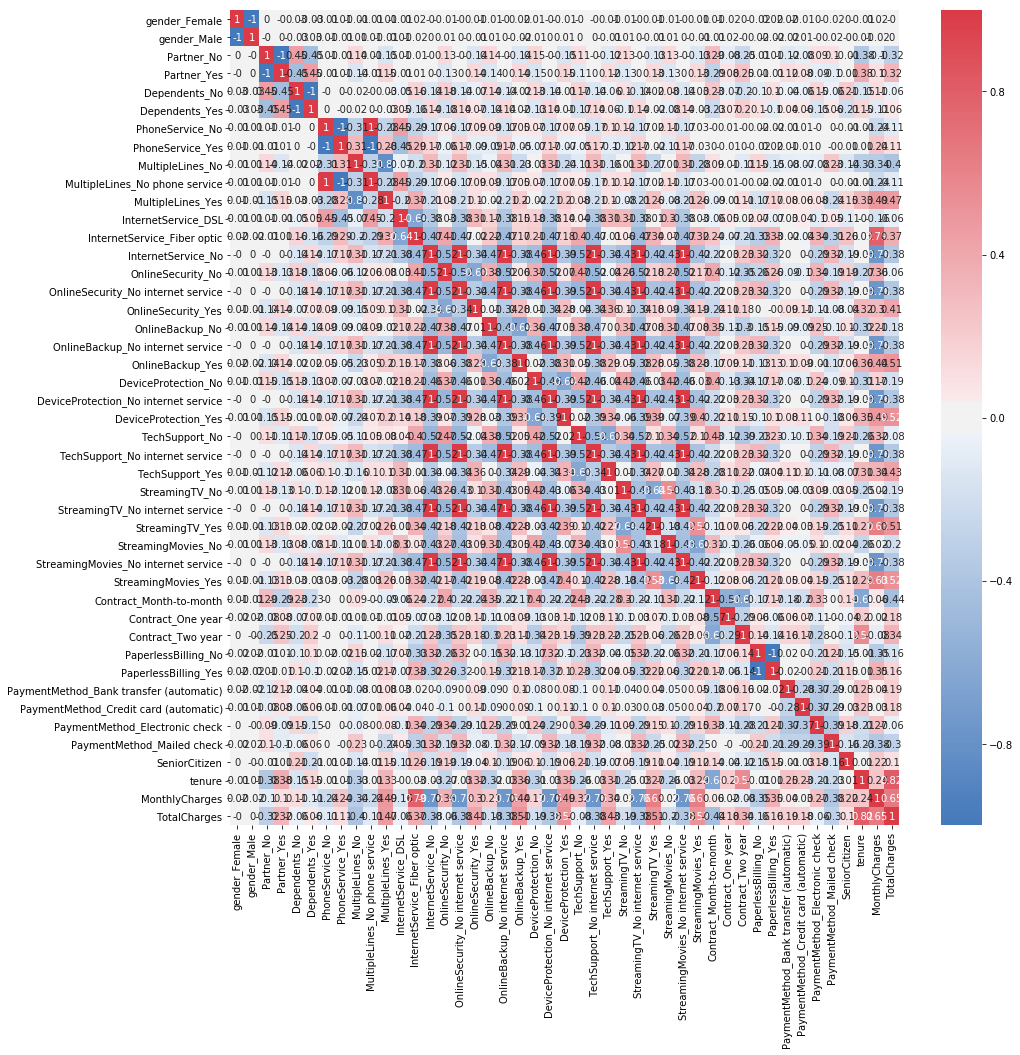

In [14]:
### Corralation matrix heatmap
# Getting correlation matrix
cor_matrix = df.corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(15,15));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=15, max_features=30, n_jobs=-1, random_state=0)
rf.fit(X_train,Y)
features = df.columns
print("----- Training Done -----Printing Score")
print(rf.score(X_train,Y))
# Scatter plot 
fi(rf,'Random Forest')

----- Training Done -----Printing Score
0.8468228612


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=15, min_samples_leaf=5, max_features=10, random_state=0)
gb.fit(X_train,y)
print("----- Training Done -----Printing Score")
print(gb.score(X_train,y))
fi(gb,'Gradient Boosting Machine')

----- Training Done -----Printing Score
0.997337593184


In [17]:
simple_test(X_train)

[0]	train-logloss:0.684301	valid-logloss:0.684778
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.415886	valid-logloss:0.433521
[200]	train-logloss:0.381019	valid-logloss:0.410075
[300]	train-logloss:0.366174	valid-logloss:0.408634
Stopping. Best iteration:
[304]	train-logloss:0.365608	valid-logloss:0.408473



### Classifiers

In [18]:
#%%file feature_extractor.py
from sklearn import preprocessing

class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, train,test):
        a = train.drop(['SeniorCitizen','tenure','MonthlyCharges','customerID'],axis=1)
        b = test.drop(['SeniorCitizen','tenure','MonthlyCharges','customerID'],axis=1)
        X_df = pd.concat([a,b])
        d = pd.get_dummies(X_df)
        n,_ = train.shape
        tr = d[:n]
        te = d[n+1:]
        tr['SeniorCitizen']= train['SeniorCitizen']
        tr['tenure']= train['tenure']
        tr['MonthlyCharges']= train['MonthlyCharges']
        te['SeniorCitizen']= test['SeniorCitizen']
        te['tenure']= test['tenure']
        te['MonthlyCharges']= test['MonthlyCharges']
        return tr.values,te.values
        

In [19]:
#%%file classifier.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        self.clf = RandomForestClassifier(
            n_estimators=2, max_leaf_nodes=2, random_state=61)
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

### Test (local testing -- should not be present for a real starting kit)

In [20]:
C = Classifier()
C.fit(X_train,y)
pred = C.predict_proba(X_test)

In [21]:
save(pred)

---File Saved---


In [22]:
#we print the score
from sklearn.metrics import log_loss

labels = pd.read_csv("hidden_data/labels_test.csv").values

print(log_loss(labels,pred))


0.499780658566
